In [ ]:
data_path = 'src/'
data_root = 'src/data/figshare'

print(f"Data root: {data_root}")

In [ ]:
import os
import h5py
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, ToPILImage
from torchvision.models import resnet50
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import SGD
from torch import max as tensor_max, sum as tensor_sum
from torch import device, cuda, Generator
import matplotlib.pyplot as plt
import numpy as np
import random

np.random.seed(5000)
torch.manual_seed(5000)
random.seed(5000)

class MatDataset2(Dataset):
    def __init__(self, mat_dir, transform=None):
        self.mat_dir = mat_dir
        self.transform = transform
        self.mat_files = [os.path.join(mat_dir, f) for f in os.listdir(mat_dir) if f.endswith('.mat')]

    def __len__(self):
        return len(self.mat_files)

    def __getitem__(self, idx):
        mat_path = self.mat_files[idx]
        with h5py.File(mat_path, 'r') as mat_file:
            image = mat_file['cjdata']['image'][:]
            label = int(mat_file['cjdata']['label'][0, 0]) - 1
            tumor_border = mat_file['cjdata']['tumorBorder'][:].T
            max_points = 200
            tumor_border_padded = np.zeros((max_points, 1))
            tumor_border_padded[:tumor_border.shape[0]] = tumor_border

            image = torch.tensor(image, dtype=torch.float32)
            if len(image.shape) == 2:
                image = image.unsqueeze(0)
                image = image.repeat(3, 1, 1)

            if self.transform:
                image = self.transform(image)
            tensorLabel = torch.tensor([0.0,0.0,0.0])
            tensorLabel[label] = 1.0
            return image, tensorLabel, tumor_border_padded


class Modelo:
    def __init__(self, train_loader, test_loader, device):
        self.device = device
        self.model = resnet50(pretrained=True)
        self.model.fc = Linear(2048, 3)
        self.model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader

    def fit(self, epochs=3, lr=0.001):
        optimizer = SGD(self.model.parameters(), lr=lr)
        criterion = CrossEntropyLoss()
        best_accuracy = 0.0

        train_accuracies = []
        test_accuracies = []

        for epoch in range(epochs):
            self.model.train()
            running_corrects = 0
            total_samples = 0
            epoch_loss = 0.0

            for idx, (train_x, train_label, _) in enumerate(self.train_loader):
                train_x = train_x.to(self.device)
                train_label = train_label.to(self.device)

                predict_y = self.model(train_x)

                error = criterion(predict_y, train_label)
                optimizer.zero_grad()
                error.backward()
                optimizer.step()
                predict_ys = tensor_max(predict_y, axis=1)[1]

                train_label_s = tensor_max(train_label, axis=1)[1]

                correct = tensor_sum(predict_ys == train_label_s).item()
                running_corrects += correct
                total_samples += train_label.size(0)
                epoch_loss += error.cpu().item()

                if (idx % 10 == 0):
                    print(f'Epoch: {epoch+1}/{epochs}, Batch: {idx+1}/{len(self.train_loader)}, Loss: {error.cpu().item():.4f}')

            epoch_accuracy = running_corrects / total_samples
            train_accuracies.append(epoch_accuracy)
            print(f'Epoch: {epoch+1}/{epochs}, Accuracy: {epoch_accuracy:.4f}, Loss: {epoch_loss:.4f}')

            self.model.eval()
            running_corrects_test = 0
            total_samples_test = 0
            test_loss = 0.0
            with torch.no_grad():
                for test_x, test_label, _ in self.test_loader:
                    test_x = test_x.to(self.device)
                    test_label = test_label.to(self.device)
                    predict_y = self.model(test_x)

                    error = criterion(predict_y, test_label)

                    predict_ys_test = tensor_max(predict_y, axis=1)[1]
                    test_label_s = tensor_max(test_label, axis=1)[1]

                    correct_test = tensor_sum(predict_ys_test == test_label_s).item()
                    total_samples_test += test_label.size(0)
                    running_corrects_test += correct_test

            test_accuracy = running_corrects_test / total_samples_test
            test_accuracies.append(test_accuracy)
            print(f'Epoch: {epoch+1}/{epochs}, Test Accuracy: {test_accuracy:.4f}')
            print(f'Epoch: {epoch+1}/{epochs}')

            if epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                model_path = f'{data_path}/tumorModelsResNet50TestPr/best_model_acc_{best_accuracy:.4f}.pkl'
                torch.save(self.model, model_path)

        plt.figure()
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('ResNet50 Accuracies')
        plt.savefig(f'{data_path}/tumorModelsResNet50TestPr/accuracies.png')

        return self.model

device = device('cuda') if cuda.is_available() else device('cpu')

generator = Generator().manual_seed(5000)

__transform__ = Compose([
    Resize(512),
    Normalize(mean=[0.5188], std=[0.3297])
])


dataset = MatDataset2(mat_dir=data_root, transform=__transform__)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

modelo = Modelo(train_loader, test_loader, device)
modelo.fit(epochs=25)


In [ ]:
from collections import Counter
def count_classes(dataset):
    class_counts = Counter()
    for _, label, _ in dataset:
        label = tensor_max(label, axis=0)[1].long().item()
        class_counts[label] += 1
    return class_counts


train_class_counts = count_classes(train_dataset)
test_class_counts = count_classes(test_dataset)

print(train_class_counts)
print(test_class_counts)

Counter({1: 995, 2: 674, 0: 475})
Counter({1: 431, 2: 256, 0: 233})


In [ ]:

# Carregue o modelo treinado
modelo.model = torch.load(f'{data_path}/tumorModelsResNet50TestPr/best_model_acc_0.9935.pkl')



In [ ]:
from torch.nn.functional import softmax
def predict(model, image):
        model.eval()

        image = image.unsqueeze(dim=0)
        output = model(image)
        preds = softmax(output, dim=1).max(dim=1).indices.item()

        return preds



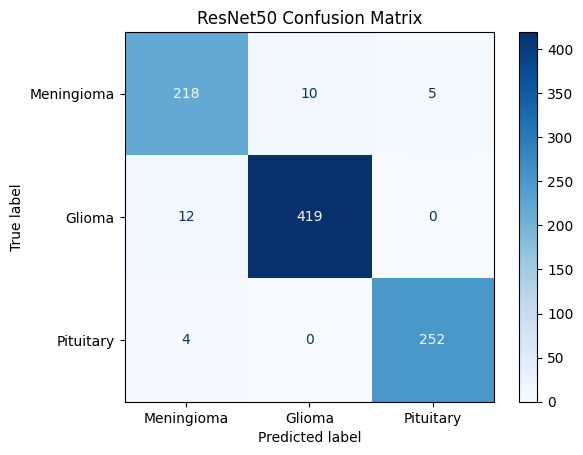

In [ ]:
preds = []
y = []
for image, label,_ in test_dataset:
    pred = predict(modelo.model, image.to(device))
    preds.append(pred)
    label = tensor_max(label, axis=0)[1].long().item()
    y.append(label)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=y, y_pred=preds, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Meningioma", "Glioma", "Pituitary"])

disp.plot(cmap='Blues')
plt.title('ResNet50 Confusion Matrix')
plt.show()

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget, ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

def applyGradCAM(model, image,  input_tensor, label, device):
    model.eval()

    target_layers = [model.layer4[-1]]

    cam = GradCAM(model=model, target_layers=target_layers)

    target = [ClassifierOutputTarget(label)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]

    image = np.array(image)

    visualization = show_cam_on_image(image , grayscale_cam, use_rgb=True)

    plt.imshow(visualization)


In [ ]:
meningioma = []
glioma = []
pituitary = []

test_dataset.dataset.mat_files.sort()
for data in test_dataset:
    test_data, test_label, tumor_border = data
    test_label = tensor_max(test_label, axis=0)[1].long().item()
    if test_label == 0:
        meningioma.append(data)
    elif test_label == 1:
        glioma.append(data)
    elif test_label == 2:
        pituitary.append(data)


list_images = meningioma[-5:] + glioma[-5:] + pituitary[-5:]

In [ ]:

for idx, (test_data, test_label, tumor_border) in enumerate(list_images):
    image = test_data.numpy().transpose(
        1, 2, 0)
    test_label = tensor_max(test_label, axis=0)[1].long().item()
    predic = modelo.model(test_data.to(device).unsqueeze(0))
    predicLabel = tensor_max(predic, axis=1)[1]

    image = (image - image.min()) / (image.max() - image.min())

    tumours = ["Meningioma", "Glioma", "Pituitary"]
    plt.title(
        f"Label: {test_label+1} - {tumours[test_label]}\n Predicted: {predicLabel.item() + 1} - {tumours[predicLabel.item()]}")

    plt.imshow(image)

    # borda
    border = np.trim_zeros(tumor_border)
    border = border.reshape(-1, 2)
    plt.plot(border[:, 1], border[:, 0], 'r', linewidth=1)
    plt.show()

    applyGradCAM(modelo.model, image, test_data.unsqueeze(0), predicLabel.item(), device)

    plt.plot(border[:, 1], border[:, 0], 'r', linewidth=1)
    # plt.savefig(f'{data_path}/gradCamCerto2/testImage-batch{idx}-image{i}.jpg')
    plt.show()

    plt.close()
    print()
